## 1. Importing Dataset

### 1.1 Mount Drive To Notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Import Dataset from Drive

In [2]:
import pandas as pd
import librosa
import librosa.display

path_set_a_timing = "/content/drive/MyDrive/Faculty of Engineering/Term 9/Pattern/Ass.3 [Heartbeat Segmentation and Classification]/Dataset/set_a_timing.csv"
path_dataset = "/content/drive/MyDrive/Faculty of Engineering/Term 9/Pattern/Ass.3 [Heartbeat Segmentation and Classification]/Dataset/"

set_a_timing = pd.read_csv(path_set_a_timing)
set_a_timing.head()

,fname,cycle,sound,location
0,set_a/normal__201102081321.wav,1,S1,10021
1,set_a/normal__201102081321.wav,1,S2,20759
2,set_a/normal__201102081321.wav,2,S1,35075
3,set_a/normal__201102081321.wav,2,S2,47244
4,set_a/normal__201102081321.wav,3,S1,62992


### 1.3 Displaying Audio sample

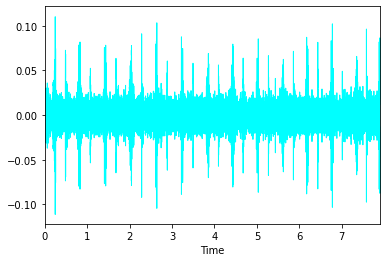

In [3]:
import librosa
import librosa.display

sample_number = 10
filename = set_a_timing.fname[sample_number]
y,sr = librosa.load(path_dataset + str(filename))
librosa.display.waveplot(y,sr=sr,x_axis='time',color='cyan')

## 2. Setting Up The Dataset

### 2.1 Genarate Features

In [72]:
import numpy as np

def noise_function(data):
    noise_value = 0.009 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    
    return data

def stretch_function(data,rate=0.6):
    
    return librosa.effects.time_stretch(data,rate)

def shift_function(data):
    
    shift_range = int(np.random.uniform(-3,3) * 1000)
    return np.roll(data,shift_range)

def pitch_function(data,sampling_rate,pitch_factor=0.3):
    
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)


def extract_function(data,sample_rate):
    
    output_result = np.array([])
    
    mean_zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero_crossing_rate))
    
    stft_output = np.abs(librosa.stft(data))
    chroma_mean = np.mean(librosa.feature.chroma_stft(S=stft_output,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_mean))
    
    mfcc_output = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_output))
    
    root_output = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_output))
    
    mel_output = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_output))
    
    return output_result

def export_function(data,sample_rate):
    Output_One = extract_function(data,sample_rate)
    result = np.array(Output_One)

    noise_output = noise_function(data)
    Output_Two = extract_function(noise_output,sample_rate)
    #result = np.vstack((result,Output_Two))
    result = np.add(result,Output_Two)
    
    stretch_output = stretch_function(data)
    stretch_pitch = pitch_function(stretch_output,sample_rate)
    Output_Three = extract_function(stretch_pitch,sample_rate)
    #result = np.vstack((result,Output_Three))
    result = np.add(result,Output_Three)
    
    return result


### 2.2 Extract the features of the audio

In [24]:
from IPython.core.pylabtools import figsize
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

def get_features(df_in):   
    features=[]     
    labels_s1 = []
    labels_s2 = []

    #For each species, determine how many augmentations are needed
    df_in=df_in.reset_index()     
    for i in df_in.fname.unique():  
      cycles = df_in.loc[df_in.fname == i].index
      for j in  range(0,len(cycles),2):
            current_row = df_in.iloc[cycles[j]]
            next_row = df_in.iloc[cycles[j+1]]

            fname = current_row.fname
            filename = path_dataset + str(fname)
            #Load the file
            y, sr = librosa.load(filename) 

            location_s1 = int(current_row.location/2)
            location_s2 = int(next_row.location/2)

            start_sample = 0
            end_sample = 0


            if len(cycles) == 2:
              start_sample = random.randrange(location_s1-1000,location_s1)
              end_sample = random.randrange(location_s2,location_s2+1000)
            elif current_row.cycle == 1:
                next_s1_location = int(df_in.iloc[cycles[j+2]].location/2)
                start_sample = random.randrange(0,location_s1)
                end_sample = random.randrange(location_s2,next_s1_location)
            elif j == len(cycles) -2: #means that we are in the last cycle
                prev_s2_location = int(df_in.iloc[cycles[j-1]].location/2)
                start_sample = random.randrange(prev_s2_location,location_s1)
                end_sample = random.randrange(location_s2,len(y))
            else:
              prev_s2_location = int(df_in.iloc[cycles[j-1]].location/2)
              next_s1_location = int(df_in.iloc[cycles[j+2]].location/2)

              if prev_s2_location > location_s1:
                start_sample = random.randrange(location_s1-500,location_s1)
              else:
                start_sample = random.randrange(prev_s2_location,location_s1)
              
              if location_s2 > next_s1_location:
                end_sample = random.randrange(location_s2,location_s2+500)
              else:
                end_sample = random.randrange(location_s2,next_s1_location)
            

            #cut the file to signal start and end  
            y_cut=y[start_sample:end_sample] 
            #generate features & output numpy array   
            data = export_function(y_cut,sr) 
            features.append(data)   

            labels_s1.append(location_s1 - start_sample)     
            labels_s2.append(location_s2 - start_sample)   
    return(np.array(features), np.array(labels_s1),np.array(labels_s2))

In [135]:
features, s1_labels, s2_lables = get_features(set_a_timing)

### 2.3 Shuffle Dataset

In [149]:
data = np.column_stack((features,s1_labels,s2_lables))
np.random.shuffle(data)
df = pd.DataFrame(data)
df.rename(columns = {162:'s1_location',163:'s2_location'},inplace = True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,s1_location,s2_location
0,0.196194,2.278570,2.191706,2.265579,2.497400,2.674816,2.389745,2.069952,1.979808,1.872160,...,0.000436,0.000404,0.000424,4.296070e-04,3.939434e-04,4.812223e-04,4.761145e-04,4.499328e-04,1641.0,8098.0
1,0.191364,2.458983,2.316895,2.108888,2.059534,2.049075,2.039491,2.183730,2.650806,2.662653,...,0.000092,0.000085,0.000073,6.462034e-05,5.115378e-05,2.812801e-05,2.150039e-05,2.323094e-05,629.0,6713.0
2,0.576024,2.532950,2.580121,2.725954,2.631374,2.519505,2.409208,2.345328,2.412182,2.409409,...,0.000003,0.000002,0.000002,2.245344e-06,1.720325e-06,1.280866e-06,1.175788e-06,1.166065e-06,2980.0,9191.0
3,0.537711,2.695092,2.795091,2.743836,2.653840,2.524132,2.515014,2.435797,2.474948,2.544080,...,0.000020,0.000023,0.000023,2.149392e-05,1.556335e-05,1.205509e-05,1.169037e-05,1.102304e-05,1684.0,7817.0
4,0.621217,2.624331,2.631286,2.612835,2.524727,2.554824,2.521058,2.403934,2.531441,2.571659,...,0.000001,0.000001,0.000001,9.701460e-07,8.743082e-07,7.907426e-07,8.937017e-07,9.755502e-07,184.0,7072.0


### 2.4 Split Dataset (train 70%, val 15%, test 15%)

In [158]:
from sklearn.model_selection import train_test_split


def split_dataset_to_train_val_test(X,y):
  #Split once to get the test and training set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.295, random_state=42, shuffle=True)
  #Split twice to get the validation set
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

  train_len = len(y_train)
  val_len = len(y_val)
  test_len = len(y_test)
  total_len = train_len + val_len + test_len

  train_per = train_len/total_len
  val_per = val_len/total_len
  test_per = test_len/total_len

  print("Train=    " + str(train_len) + " samples   ratio= " + f'{train_per:.2f}' + "%")
  print("Validate= " + str(val_len) + " samples    ratio= " + f'{val_per:.2f}' + "%")
  print("Test=     " + str(test_len) + " samples    ratio= " + f'{test_per:.2f}' + "%")
  return (X_train,X_val,X_test,y_train,y_val,y_test)

In [168]:
X = df.drop(['s1_location'],axis=1)
X = X.drop(['s2_location'],axis=1)
y1 = df.s1_location
y2 = df.s2_location

print('S1 Dataset Splits:')
X1_train, X1_val, X1_test, y1_train, y1_val, y1_test = split_dataset_to_train_val_test(X,y1)
print('------------------------')
print()
print('S2 Dataset Splits:')
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = split_dataset_to_train_val_test(X,y2)
print('------------------------')

S1 Dataset Splits:
Train=    137 samples   ratio= 0.70%
Validate= 29 samples    ratio= 0.15%
Test=     29 samples    ratio= 0.15%
------------------------

S2 Dataset Splits:
Train=    137 samples   ratio= 0.70%
Validate= 29 samples    ratio= 0.15%
Test=     29 samples    ratio= 0.15%
------------------------


### 2.4 Normalize Data

In [172]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X1_train_normalized = scaler.fit_transform(X1_train)
X1_val_normalized = scaler.fit_transform(X1_val)
X1_test_normalized = scaler.fit_transform(X1_test)

X2_train_normalized = scaler.fit_transform(X2_train)
X2_val_normalized = scaler.fit_transform(X2_val)
X2_test_normalized = scaler.fit_transform(X2_test)

## 3. Building The Models & Evaluation

### 3.1 FNN Model

In [193]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error


	# create model
FNNmodel1 = Sequential()
FNNmodel1.add(Dense(512, input_dim=162, kernel_initializer='normal', activation='relu'))
FNNmodel1.add(Dropout(0.5))
FNNmodel1.add(Dense(256, kernel_initializer='normal', activation='relu'))
FNNmodel1.add(Dropout(0.5))
FNNmodel1.add(Dense(16, kernel_initializer='normal', activation='relu'))
FNNmodel1.add(Dense(1, kernel_initializer='normal'))

FNNmodel2 = Sequential()
FNNmodel2.add(Dense(512, input_dim=162, kernel_initializer='normal', activation='relu'))
FNNmodel2.add(Dropout(0.5))
FNNmodel2.add(Dense(256, kernel_initializer='normal', activation='relu'))
FNNmodel2.add(Dropout(0.5))
FNNmodel2.add(Dense(16, kernel_initializer='normal', activation='relu'))
FNNmodel2.add(Dense(1, kernel_initializer='normal'))

FNNmodel1.compile(loss='mean_squared_error', optimizer='adam')
FNNmodel2.compile(loss='mean_squared_error', optimizer='adam')
history1 = FNNmodel1.fit(X1_train_normalized, y1_train, epochs=100, validation_data= (X1_val_normalized, y1_val))
history2 = FNNmodel2.fit(X2_train_normalized, y2_train, epochs=100, validation_data= (X2_val_normalized, y2_val))

Epoch 1/100
5/5 [==============================] - 1s 73ms/step - loss: 34895640.0000 - val_loss: 31209746.0000
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 34892804.0000 - val_loss: 31203592.0000
Epoch 3/100
5/5 [==============================] - 0s 29ms/step - loss: 34885520.0000 - val_loss: 31188744.0000
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 34871072.0000 - val_loss: 31156294.0000
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 34836692.0000 - val_loss: 31092190.0000
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 34779344.0000 - val_loss: 30977620.0000
Epoch 7/100
5/5 [==============================] - 0s 25ms/step - loss: 34666596.0000 - val_loss: 30777640.0000
Epoch 8/100
5/5 [==============================] - 0s 21ms/step - loss: 34492524.0000 - val_loss: 30443904.0000
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 34163580.0000 - val_loss: 299140

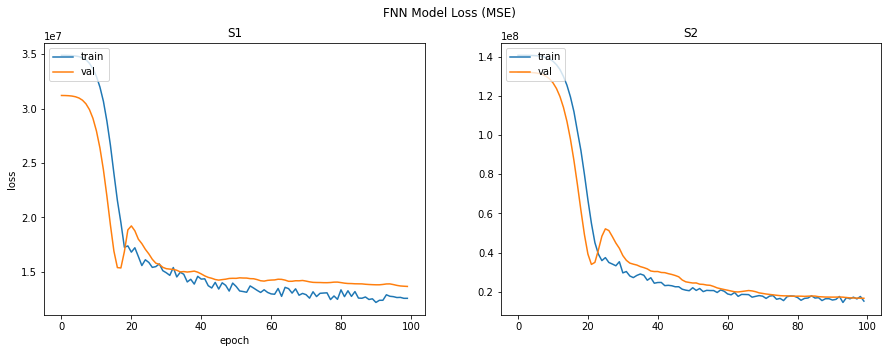

In [194]:
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('FNN Model Loss (MSE)')

ax1.plot(history1.history['loss'])
ax1.plot(history1.history['val_loss'])
ax1.set_title('S1')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('S2')
ax1.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'val'], loc='upper left')

1/1 [==============================] - 0s 21ms/step


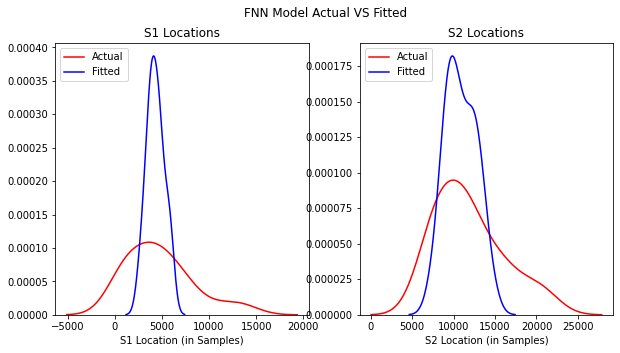

In [216]:
import seaborn as sns

y1_predicted = FNNmodel1.predict(X1_test_normalized)
y2_predicted = FNNmodel2.predict(X2_test_normalized)


fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('FNN Model Actual VS Fitted')


ax1 = sns.distplot(y1_test, hist=False, color="r", label="Actual Value", ax=ax1)
sns.distplot(y1_predicted, hist=False, color="b", label="Fitted Values" , ax=ax1)


ax1.set_title('S1 Locations')
ax1.set(xlabel='S1 Location (in Samples)', ylabel='')
ax1.legend(['Actual', 'Fitted'], loc='upper left')

ax2 = sns.distplot(y2_test, hist=False, color="r", label="Actual Value",ax=ax2)
sns.distplot(y2_predicted, hist=False, color="b", label="Fitted Values" , ax=ax2)


ax2.set_title('S2 Locations')
ax2.set(xlabel='S2 Location (in Samples)', ylabel='')
ax2.legend(['Actual', 'Fitted'], loc='upper left')



### 3.2 CNN Model

In [217]:
X1_train_normalized_reshaped = X1_train_normalized.reshape(X1_train_normalized.shape[0], 162, 1)
X1_val_normalized_reshaped = X1_val_normalized.reshape(X1_val_normalized.shape[0],162, 1)
X1_test_normalized_reshaped = X1_test_normalized.reshape(X1_test_normalized.shape[0],162, 1)

X2_train_normalized_reshaped = X2_train_normalized.reshape(X2_train_normalized.shape[0], 162, 1)
X2_val_normalized_reshaped = X2_val_normalized.reshape(X2_val_normalized.shape[0],162, 1)
X2_test_normalized_reshaped = X2_test_normalized.reshape(X2_test_normalized.shape[0],162, 1)

In [218]:
from keras import models, layers
from keras.layers import Dense, Dropout, Flatten, BatchNormalization,MaxPooling1D, Conv1D
                        

input_shape=(162, 1)
CNNmodel1 = Sequential()

CNNmodel1.add(Conv1D(512,5,strides=1,padding="same",activation="relu",input_shape=input_shape))
CNNmodel1.add(BatchNormalization())
CNNmodel1.add(MaxPooling1D(3,strides=2,padding="same"))

CNNmodel1.add(Conv1D(256,4,strides=1,padding="same",activation="relu"))
CNNmodel1.add(Dropout(0.3))
CNNmodel1.add(MaxPooling1D(3,strides=2,padding="same"))

CNNmodel1.add(Conv1D(128,4,strides=1,padding="same",activation="relu"))
CNNmodel1.add(Dropout(0.3))
CNNmodel1.add(MaxPooling1D(3,strides=2,padding="same"))

CNNmodel1.add(Flatten())
CNNmodel1.add(Dense(256, activation='relu'))
CNNmodel1.add(Dropout(0.3))

CNNmodel1.add(Dense(1))


CNNmodel2 = Sequential()

CNNmodel2.add(Conv1D(512,5,strides=1,padding="same",activation="relu",input_shape=input_shape))
CNNmodel2.add(BatchNormalization())
CNNmodel2.add(MaxPooling1D(3,strides=2,padding="same"))

CNNmodel2.add(Conv1D(256,4,strides=1,padding="same",activation="relu"))
CNNmodel2.add(Dropout(0.3))
CNNmodel2.add(MaxPooling1D(3,strides=2,padding="same"))

CNNmodel2.add(Conv1D(128,4,strides=1,padding="same",activation="relu"))
CNNmodel2.add(Dropout(0.3))
CNNmodel2.add(MaxPooling1D(3,strides=2,padding="same"))

CNNmodel2.add(Flatten())
CNNmodel2.add(Dense(256, activation='relu'))
CNNmodel2.add(Dropout(0.3))

CNNmodel2.add(Dense(1))

In [219]:
import tensorflow as tf

CNNmodel1.compile(optimizer='adam',loss='mean_squared_error', metrics=["mean_squared_error"])
CNNmodel2.compile(optimizer='adam',loss='mean_squared_error', metrics=["mean_squared_error"])

In [220]:
history1 = CNNmodel1.fit(X1_train_normalized_reshaped, y1_train, epochs=100, validation_data= (X1_val_normalized_reshaped, y1_val))
history2 = CNNmodel2.fit(X2_train_normalized_reshaped, y2_train, epochs=100, validation_data= (X2_val_normalized_reshaped, y2_val))

Epoch 1/100
5/5 [==============================] - 3s 347ms/step - loss: 34299352.0000 - mean_squared_error: 34299352.0000 - val_loss: 31047884.0000 - val_mean_squared_error: 31047884.0000
Epoch 2/100
5/5 [==============================] - 3s 513ms/step - loss: 21843128.0000 - mean_squared_error: 21843128.0000 - val_loss: 29234200.0000 - val_mean_squared_error: 29234200.0000
Epoch 3/100
5/5 [==============================] - 2s 399ms/step - loss: 20629062.0000 - mean_squared_error: 20629062.0000 - val_loss: 30292300.0000 - val_mean_squared_error: 30292300.0000
Epoch 4/100
5/5 [==============================] - 2s 417ms/step - loss: 16863100.0000 - mean_squared_error: 16863100.0000 - val_loss: 30685564.0000 - val_mean_squared_error: 30685564.0000
Epoch 5/100
5/5 [==============================] - 2s 289ms/step - loss: 15969958.0000 - mean_squared_error: 15969958.0000 - val_loss: 30233080.0000 - val_mean_squared_error: 30233080.0000
Epoch 6/100
5/5 [==============================] - 2s 2

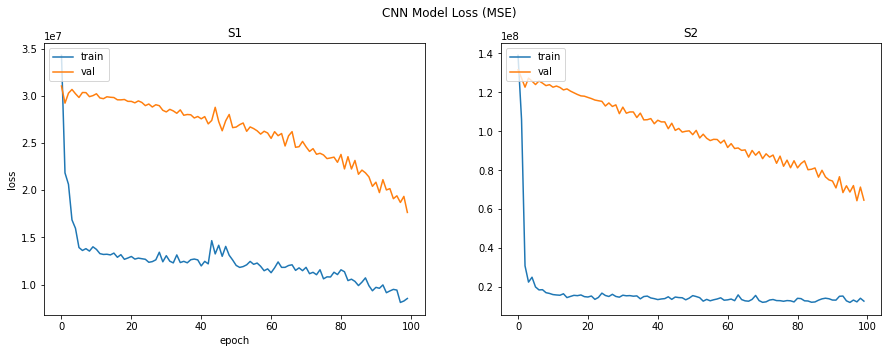

In [221]:
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('CNN Model Loss (MSE)')

ax1.plot(history1.history['loss'])
ax1.plot(history1.history['val_loss'])
ax1.set_title('S1')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('S2')
ax1.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'val'], loc='upper left')

1/1 [==============================] - 0s 176ms/step


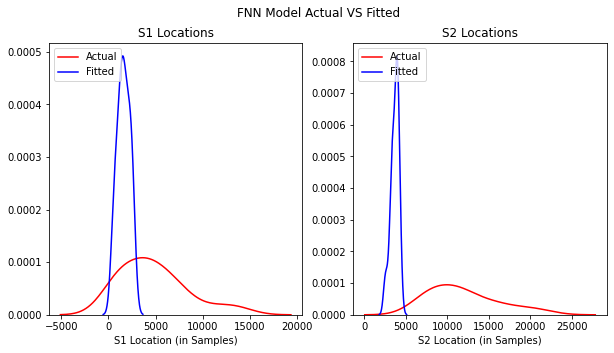

In [222]:
y1_predicted = CNNmodel1.predict(X1_test_normalized)
y2_predicted = CNNmodel2.predict(X2_test_normalized)


fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('FNN Model Actual VS Fitted')


ax1 = sns.distplot(y1_test, hist=False, color="r", label="Actual Value", ax=ax1)
sns.distplot(y1_predicted, hist=False, color="b", label="Fitted Values" , ax=ax1)


ax1.set_title('S1 Locations')
ax1.set(xlabel='S1 Location (in Samples)', ylabel='')
ax1.legend(['Actual', 'Fitted'], loc='upper left')

ax2 = sns.distplot(y2_test, hist=False, color="r", label="Actual Value",ax=ax2)
sns.distplot(y2_predicted, hist=False, color="b", label="Fitted Values" , ax=ax2)


ax2.set_title('S2 Locations')
ax2.set(xlabel='S2 Location (in Samples)', ylabel='')
ax2.legend(['Actual', 'Fitted'], loc='upper left')